In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from math import sqrt


/tmp/ipykernel_2467/3097539354.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters_by_type = df.groupby([pd.Grouper(freq='M', key='incident_begin_date'), 'incident_type']).size()
2025-01-14 23:43:32.603195: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X_train shape: (520, 24, 40), y_train shape: (520,)
X_test shape: (130, 24, 40), y_test shape: (130,)
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 2.8047e-04 - val_loss: 0.0039
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.4979e-05 - val_loss: 0.0039
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.0761e-06 - val_loss: 0.0039
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.9183e-06 - val_loss: 0.0039
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.7478e-06 - val_loss: 0.0039
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1524e-06 - val_loss: 0.0039
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0534e-06 - val_loss: 0.0038
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.6096e-07 - val_loss: 0.0039
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.2160e-07 - val_loss: 0.0038
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.8326e-07 - val_loss: 0.0038
Epoch 1

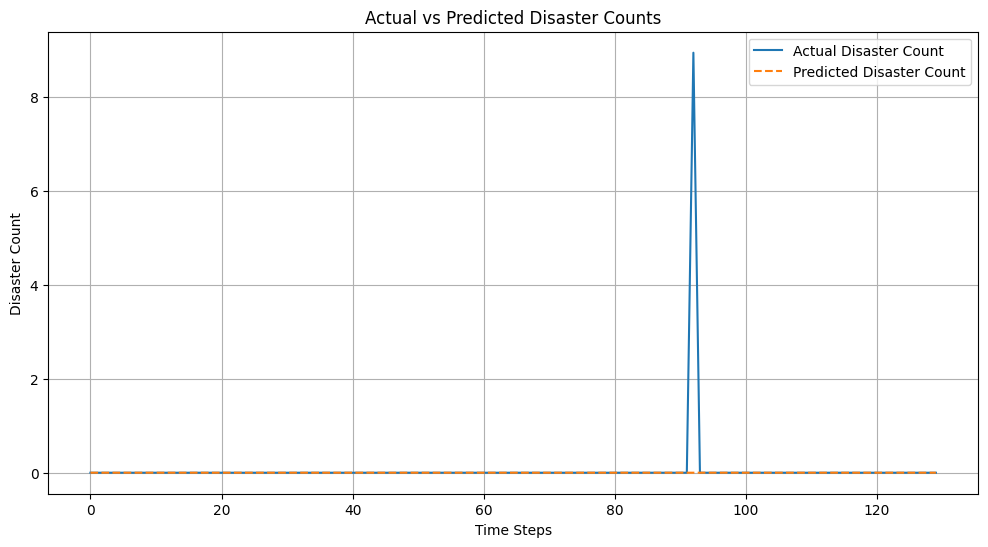

In [8]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.losses import Huber

# Step 2: Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date'])
df.sort_values('incident_begin_date', inplace=True)

# Filter for the top 10 disaster types
disaster_counts = df['incident_type'].value_counts()
top_10_disaster_types = disaster_counts.head(10).index
df = df[df['incident_type'].isin(top_10_disaster_types)]

# Aggregate monthly disaster counts by type
monthly_disasters_by_type = df.groupby([pd.Grouper(freq='M', key='incident_begin_date'), 'incident_type']).size()
monthly_disasters_by_type = monthly_disasters_by_type.unstack(fill_value=0)

# Reset index and reformat
monthly_disasters_by_type.reset_index(inplace=True)
monthly_disasters_by_type.set_index('incident_begin_date', inplace=True)

# Step 3: Preprocess Data
# Log transform all disaster type columns
log_transformed_data = np.log1p(monthly_disasters_by_type)
monthly_disasters_by_type = log_transformed_data.copy()

# Add lagged features for each disaster type
for col in monthly_disasters_by_type.columns:
    monthly_disasters_by_type[f'{col}_lag_1'] = monthly_disasters_by_type[col].shift(1)
    monthly_disasters_by_type[f'{col}_lag_2'] = monthly_disasters_by_type[col].shift(2)
    monthly_disasters_by_type[f'{col}_lag_3'] = monthly_disasters_by_type[col].shift(3)

# Drop rows with NaN values
monthly_disasters_by_type.dropna(inplace=True)

# Normalize all columns
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters_by_type)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters_by_type.columns, index=monthly_disasters_by_type.index)

# Step 4: Create Sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values  # Input sequence
        label = data.iloc[i + seq_length, 0]     # Output label (disaster count for the first disaster type)
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Use a sequence length of 24 months
seq_length = 24
X, y = create_sequences(scaled_df, seq_length)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Step 6: Build the LSTM Model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    SeqSelfAttention(attention_activation='sigmoid'),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Predict one value for disaster count
])

# Compile the model with Huber loss
model.compile(optimizer='adam', loss=Huber())

# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the Model
# Make predictions
y_pred = model.predict(X_test)

# Rescale predictions and actual values back to the original scale
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, X_test[:, -1, 1:])))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted disaster counts
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Disaster Count')
plt.plot(y_pred_rescaled, label='Predicted Disaster Count', linestyle='--')
plt.title('Actual vs Predicted Disaster Counts')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count')
plt.legend()
plt.grid()
plt.show()


In [9]:
# Get unique disaster types and their counts
disaster_type_counts = df['incident_type'].value_counts()

# Display disaster types and their counts
print("Disaster Types and Their Counts:")
print(disaster_type_counts)


Disaster Types and Their Counts:
incident_type
Severe Storm        17162
Hurricane           11937
Flood               10311
Biological           7672
Snowstorm            3704
Fire                 3607
Severe Ice Storm     2942
Tornado              1569
Drought              1225
Coastal Storm         636
Name: count, dtype: int64


In [10]:
# Group "Severe Ice Storm" and "Snowstorm" into "Winter Storm"
df['incident_type'] = df['incident_type'].replace({
    'Severe Ice Storm': 'Winter Storm',
    'Snowstorm': 'Winter Storm'
})

# Verify the updated disaster types
print("Updated Disaster Types:")
print(df['incident_type'].value_counts())


Updated Disaster Types:
incident_type
Severe Storm     17162
Hurricane        11937
Flood            10311
Biological        7672
Winter Storm      6646
Fire              3607
Tornado           1569
Drought           1225
Coastal Storm      636
Name: count, dtype: int64


In [11]:
# Remove "Biological" incidents
df = df[df['incident_type'] != 'Biological']

# Verify the updated disaster types
print("Disaster Types After Removing Biological:")
print(df['incident_type'].value_counts())


Disaster Types After Removing Biological:
incident_type
Severe Storm     17162
Hurricane        11937
Flood            10311
Winter Storm      6646
Fire              3607
Tornado           1569
Drought           1225
Coastal Storm      636
Name: count, dtype: int64


In [12]:
# Re-aggregate monthly disaster counts by type
monthly_disasters_by_type = df.groupby([pd.Grouper(freq='M', key='incident_begin_date'), 'incident_type']).size()
monthly_disasters_by_type = monthly_disasters_by_type.unstack(fill_value=0)

# Verify the updated monthly disaster counts
print("Monthly Disaster Counts (After Updates):")
print(monthly_disasters_by_type.head())


Monthly Disaster Counts (After Updates):
incident_type              Coastal Storm  Drought  Fire  Flood  Hurricane  \
incident_begin_date                                                         
1953-05-31 00:00:00+00:00              0        0     0      1          0   
1953-06-30 00:00:00+00:00              0        0     0      3          0   
1953-07-31 00:00:00+00:00              0        0     1      0          0   
1953-10-31 00:00:00+00:00              0        0     0      1          0   
1953-12-31 00:00:00+00:00              0        0     0      0          0   

incident_type              Severe Storm  Tornado  Winter Storm  
incident_begin_date                                             
1953-05-31 00:00:00+00:00             0        2             0  
1953-06-30 00:00:00+00:00             0        3             0  
1953-07-31 00:00:00+00:00             0        0             0  
1953-10-31 00:00:00+00:00             0        0             0  
1953-12-31 00:00:00+00:00    

/tmp/ipykernel_2467/2973439389.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters_by_type = df.groupby([pd.Grouper(freq='M', key='incident_begin_date'), 'incident_type']).size()


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the updated disaster counts
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters_by_type)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters_by_type.columns, index=monthly_disasters_by_type.index)

# Verify the scaled data
print("Scaled Data (After Updates):")
print(scaled_df.head())


Scaled Data (After Updates):
incident_type              Coastal Storm  Drought      Fire     Flood  \
incident_begin_date                                                     
1953-05-31 00:00:00+00:00            0.0      0.0  0.000000  0.003012   
1953-06-30 00:00:00+00:00            0.0      0.0  0.000000  0.009036   
1953-07-31 00:00:00+00:00            0.0      0.0  0.002976  0.000000   
1953-10-31 00:00:00+00:00            0.0      0.0  0.000000  0.003012   
1953-12-31 00:00:00+00:00            0.0      0.0  0.000000  0.000000   

incident_type              Hurricane  Severe Storm   Tornado  Winter Storm  
incident_begin_date                                                         
1953-05-31 00:00:00+00:00        0.0           0.0  0.010695           0.0  
1953-06-30 00:00:00+00:00        0.0           0.0  0.016043           0.0  
1953-07-31 00:00:00+00:00        0.0           0.0  0.000000           0.0  
1953-10-31 00:00:00+00:00        0.0           0.0  0.000000           0.0

In [14]:
# Create sequences for modeling
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values  # Input sequence
        label = data.iloc[i + seq_length].values  # Output labels (all disaster types)
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Use a sequence length of 24 months
seq_length = 24
X, y = create_sequences(scaled_df, seq_length)


In [15]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (522, 24, 8), y_train shape: (522, 8)
X_test shape: (131, 24, 8), y_test shape: (131, 8)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the updated LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1])  # Output one value per disaster type
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0046 - val_l

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
RMSE for Coastal Storm: 9.164800796354957
RMSE for Drought: 3.3725085485131627
RMSE for Fire: 15.162142188608593
RMSE for Flood: 41.89042328978965
RMSE for Hurricane: 114.09961684040991
RMSE for Severe Storm: 59.58167406641328
RMSE for Tornado: 8.22003604935956
RMSE for Winter Storm: 82.9641276121652


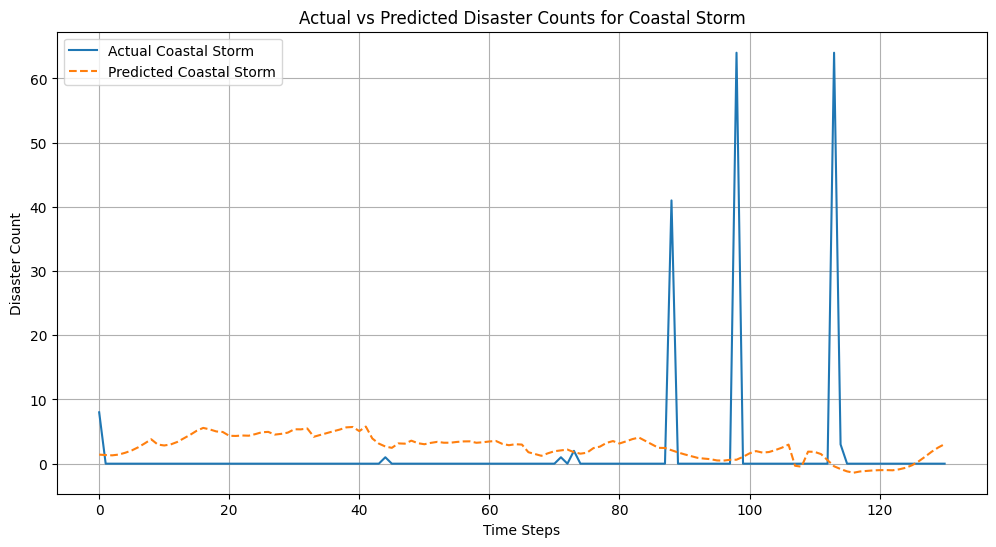

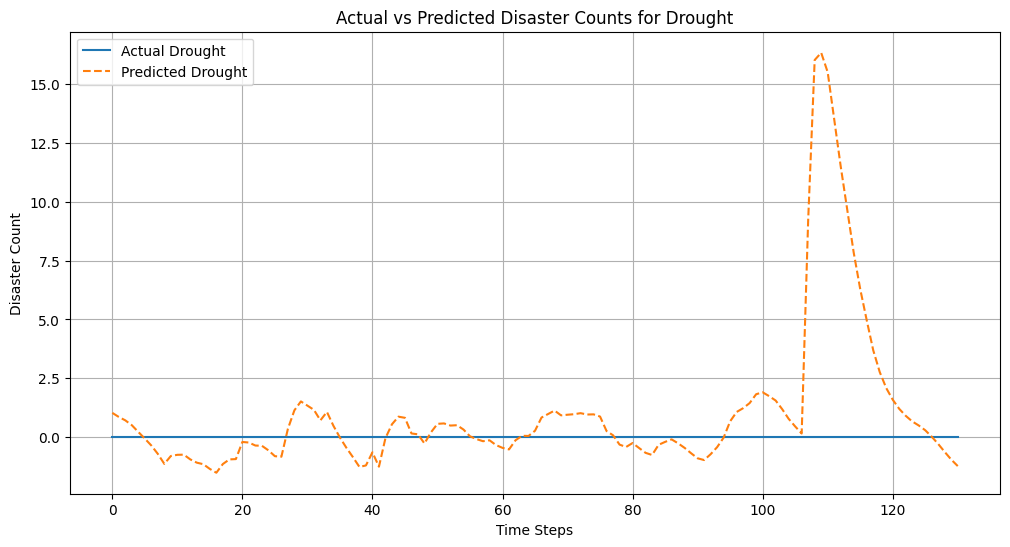

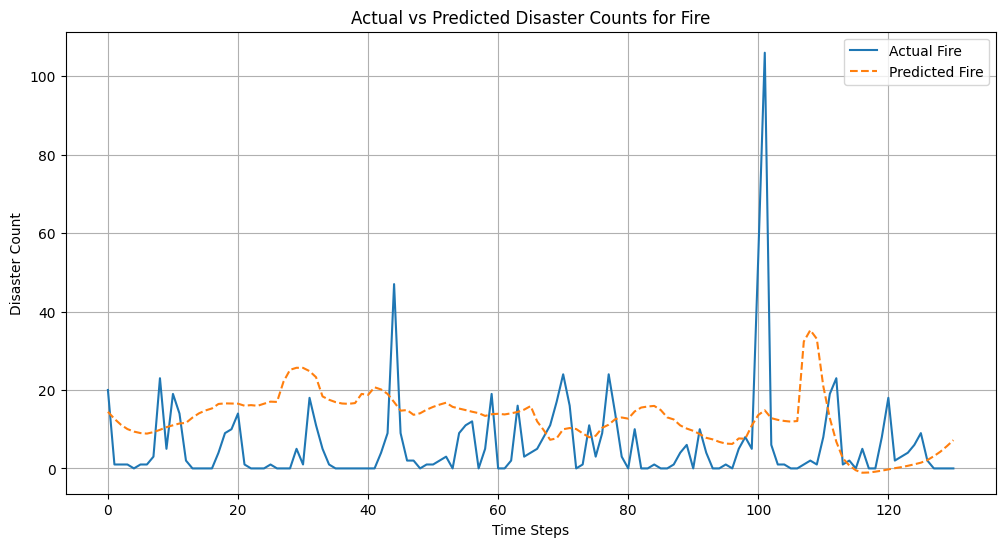

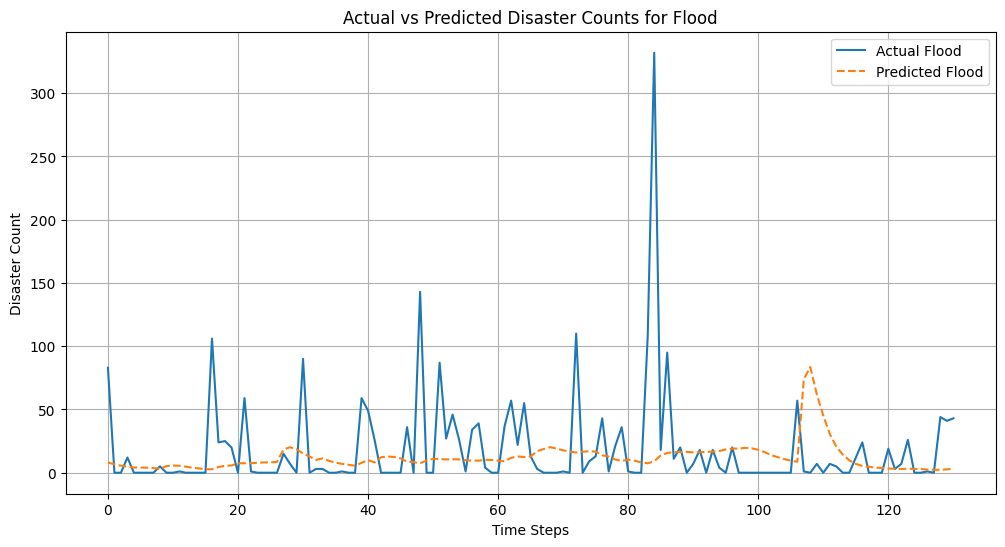

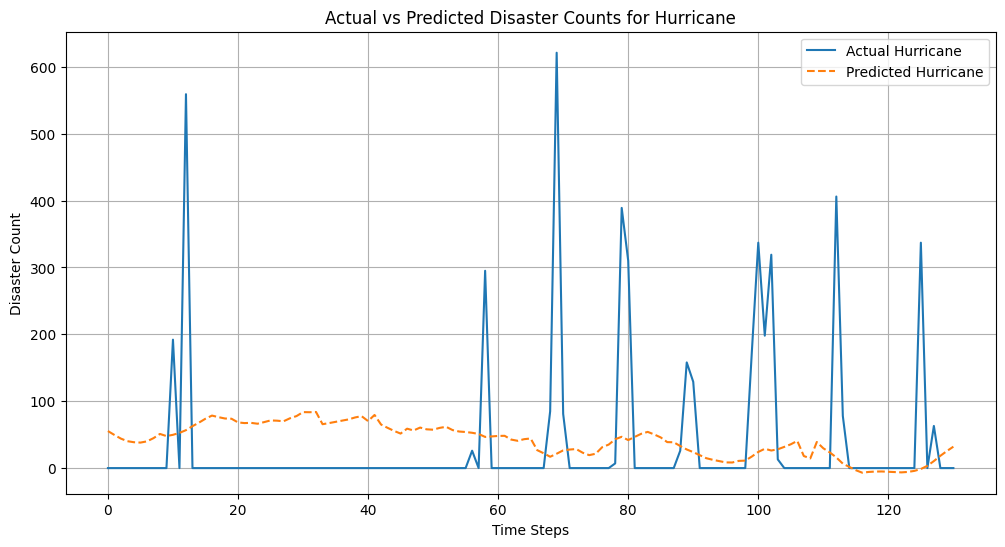

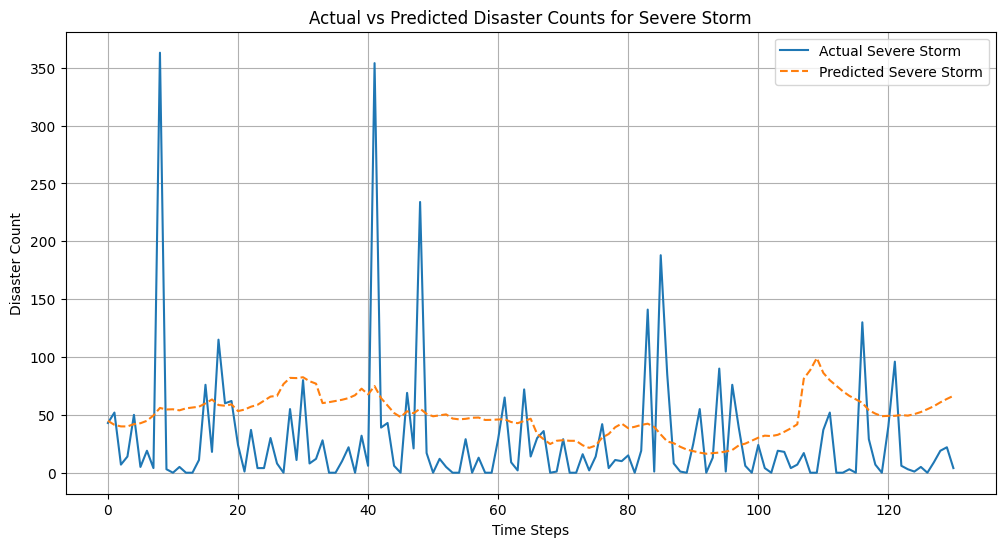

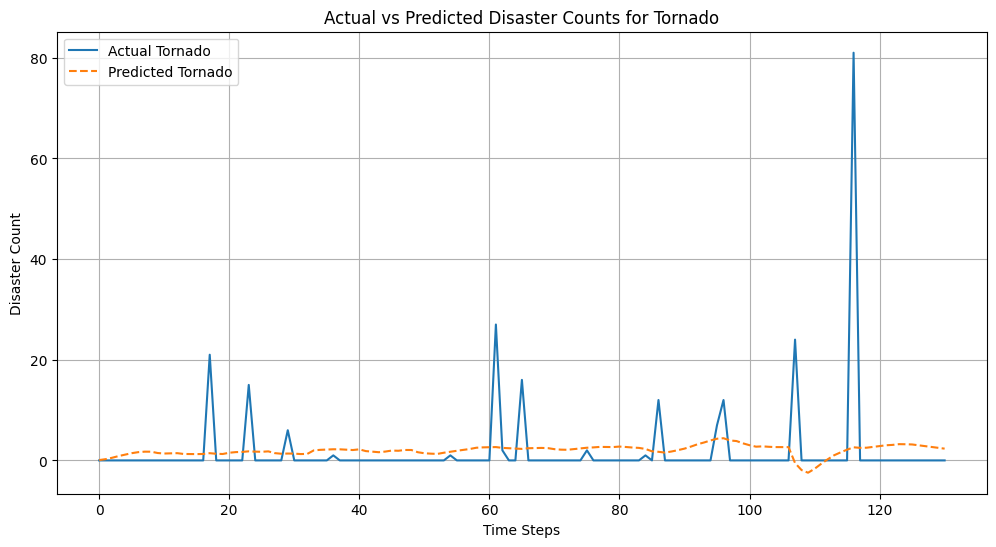

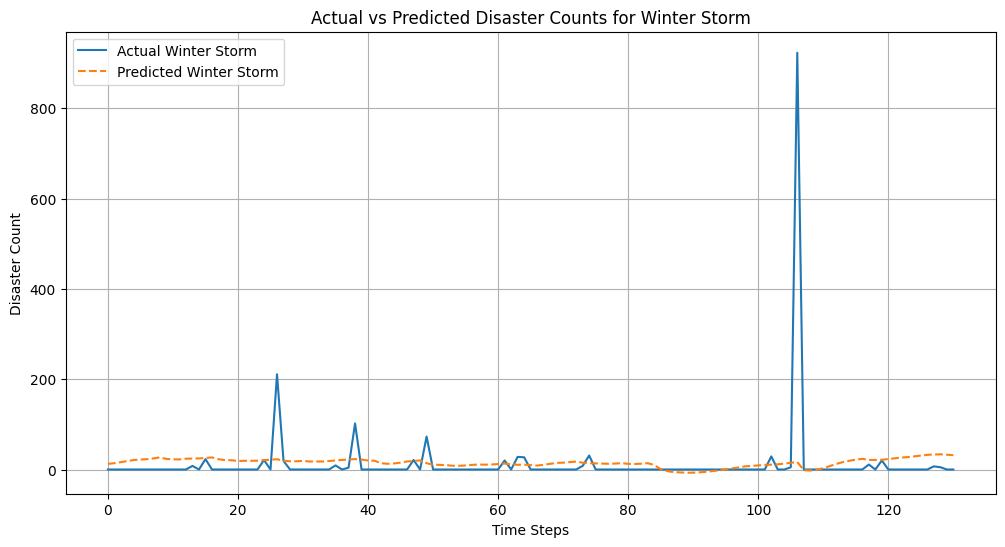

In [17]:
# Make predictions
y_pred = model.predict(X_test)

# Rescale predictions and actual values back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate RMSE for each disaster type
from sklearn.metrics import mean_squared_error

for i, col in enumerate(monthly_disasters_by_type.columns):
    rmse = np.sqrt(mean_squared_error(y_test_rescaled[:, i], y_pred_rescaled[:, i]))
    print(f"RMSE for {col}: {rmse}")

# Plot actual vs predicted disaster counts for each type
for i, col in enumerate(monthly_disasters_by_type.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled[:, i], label=f'Actual {col}')
    plt.plot(y_pred_rescaled[:, i], label=f'Predicted {col}', linestyle='--')
    plt.title(f'Actual vs Predicted Disaster Counts for {col}')
    plt.xlabel('Time Steps')
    plt.ylabel('Disaster Count')
    plt.legend()
    plt.grid()
    plt.show()


In [18]:
# Balance the dataset by undersampling dominant disaster types
balanced_df = pd.concat([
    df[df['incident_type'] == disaster].sample(n=500, random_state=42)  # Adjust 'n' based on balance
    if count > 500 else df[df['incident_type'] == disaster]
    for disaster, count in df['incident_type'].value_counts().items()
])

# Verify the balanced dataset
print(balanced_df['incident_type'].value_counts())


incident_type
Severe Storm     500
Hurricane        500
Flood            500
Winter Storm     500
Fire             500
Tornado          500
Drought          500
Coastal Storm    500
Name: count, dtype: int64


In [19]:
# Normalize each disaster type independently
scaler_dict = {}
scaled_disasters = []

for col in monthly_disasters_by_type.columns:
    scaler = MinMaxScaler()
    scaled_col = scaler.fit_transform(monthly_disasters_by_type[[col]])
    scaler_dict[col] = scaler  # Store scaler for inverse transformation
    scaled_disasters.append(pd.DataFrame(scaled_col, columns=[col]))

# Combine normalized data
scaled_df = pd.concat(scaled_disasters, axis=1)


In [20]:
# Add lagged features for each disaster type
for col in monthly_disasters_by_type.columns:
    monthly_disasters_by_type[f'{col}_lag_1'] = monthly_disasters_by_type[col].shift(1)
    monthly_disasters_by_type[f'{col}_lag_2'] = monthly_disasters_by_type[col].shift(2)

# Drop NaN values after adding lagged features
monthly_disasters_by_type.dropna(inplace=True)


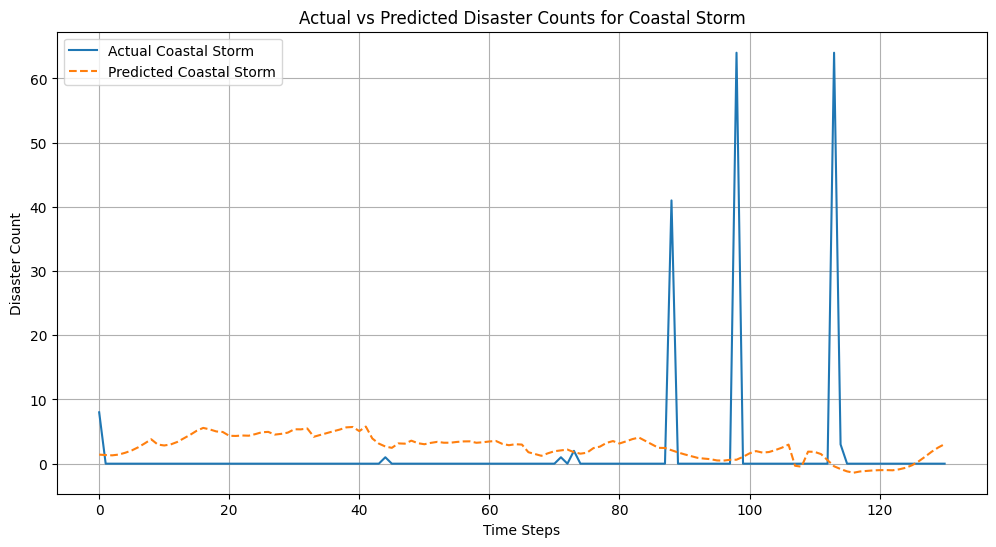

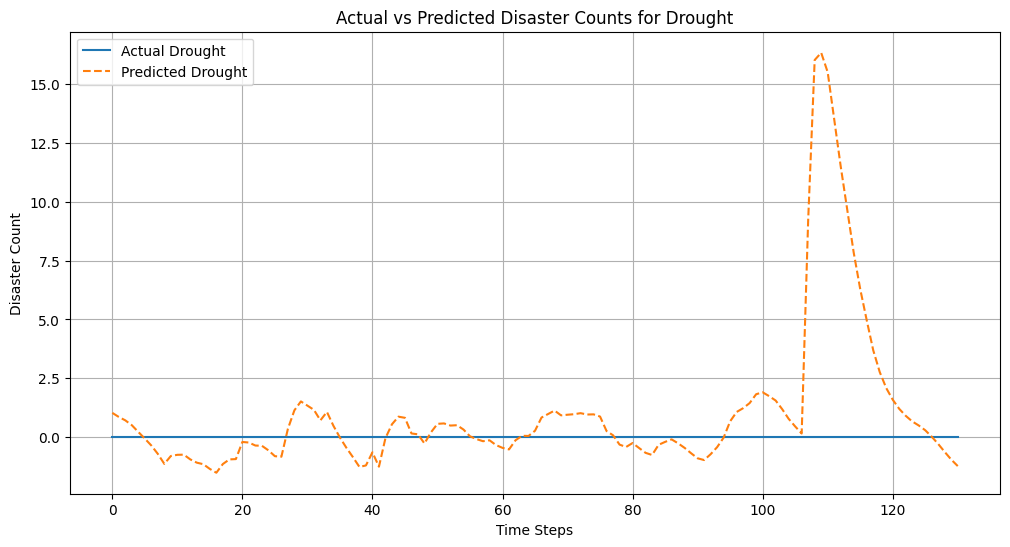

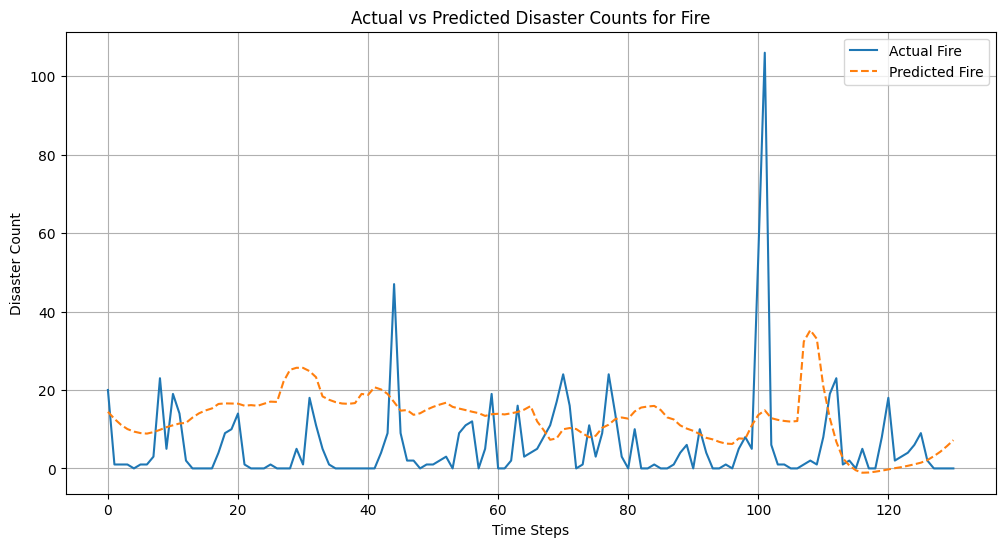

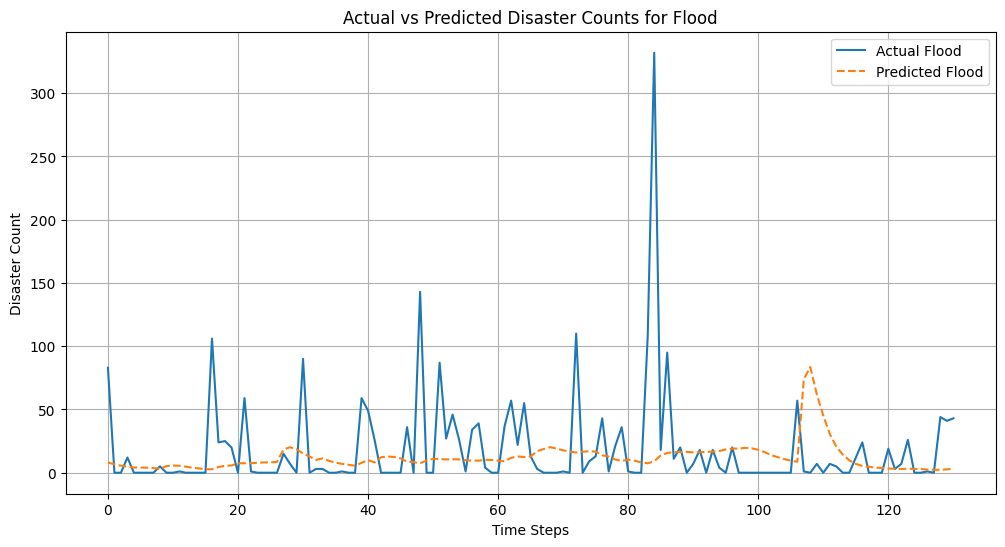

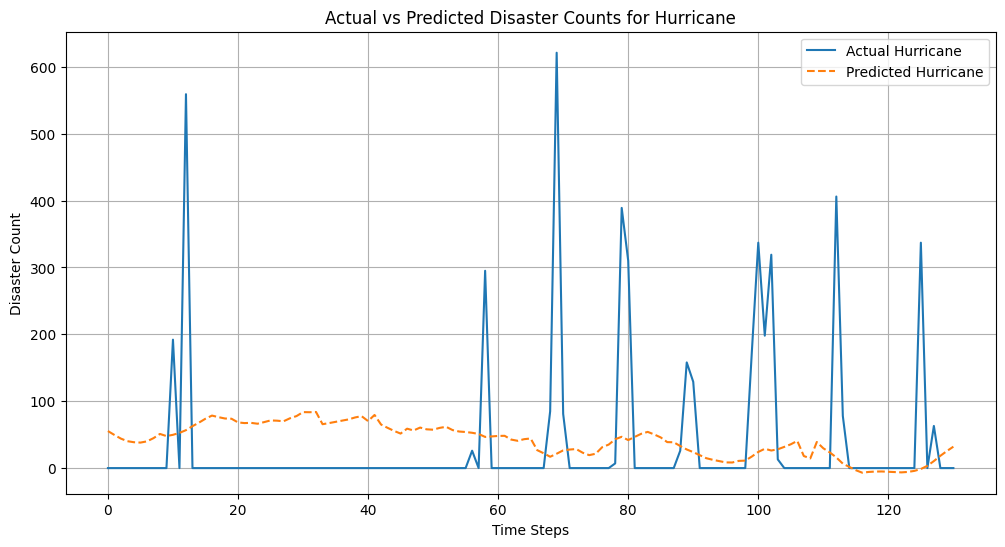

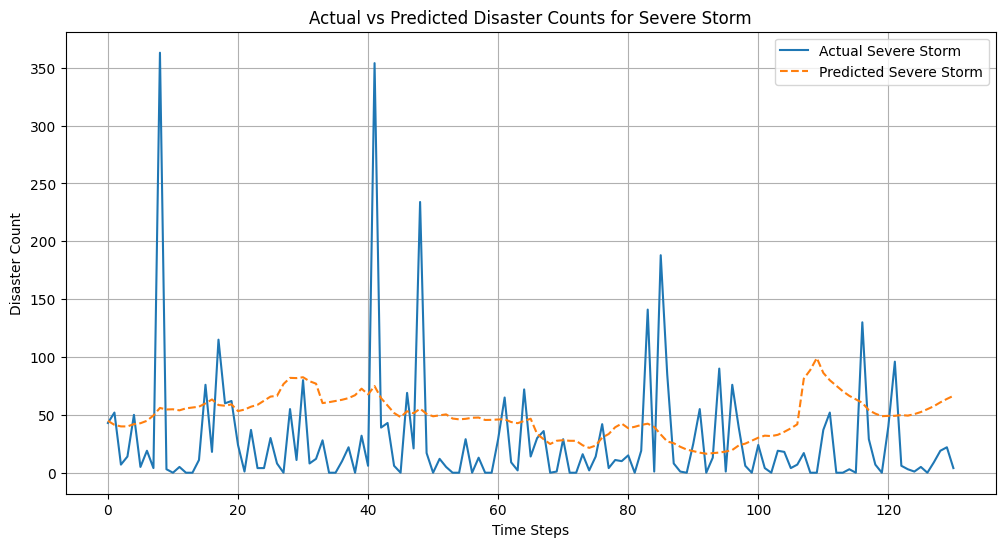

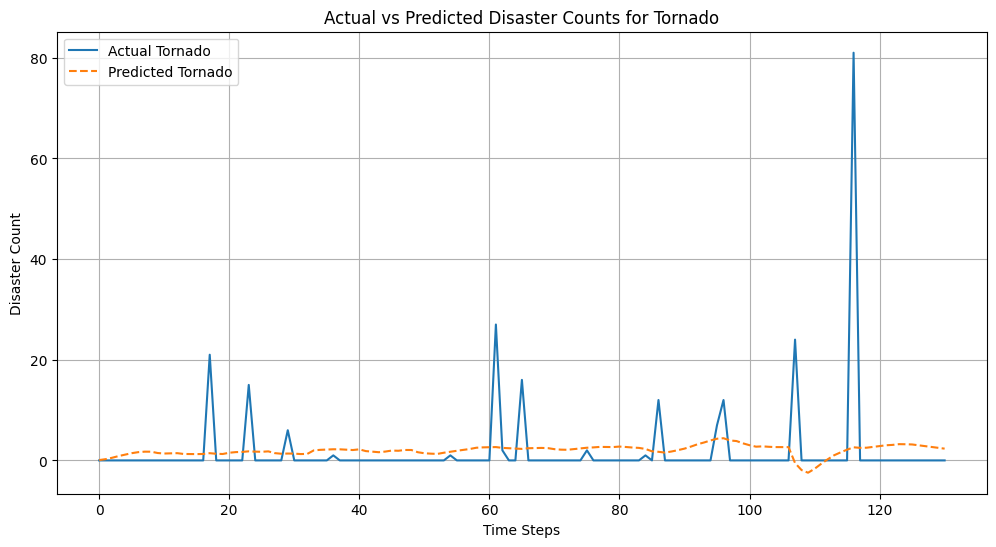

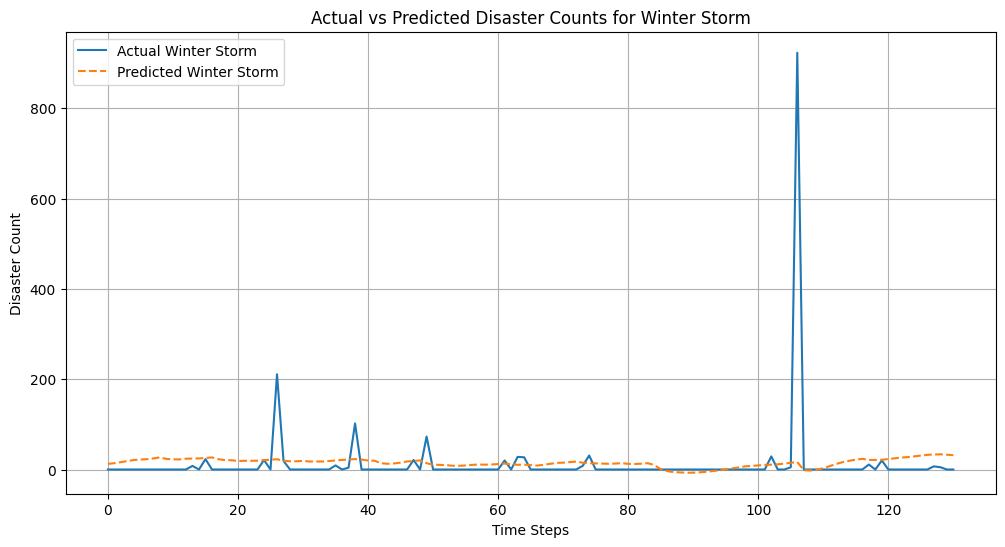

IndexError: index 8 is out of bounds for axis 1 with size 8

<Figure size 1200x600 with 0 Axes>

In [21]:
# Plot actual vs predicted disaster counts for each type
for i, col in enumerate(monthly_disasters_by_type.columns):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled[:, i], label=f'Actual {col}')
    plt.plot(y_pred_rescaled[:, i], label=f'Predicted {col}', linestyle='--')
    plt.title(f'Actual vs Predicted Disaster Counts for {col}')
    plt.xlabel('Time Steps')
    plt.ylabel('Disaster Count')
    plt.legend()
    plt.grid()
    plt.show()
